An attempt to create an information notebook containing several interesting approaches to solving the problem of house prices regression

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from catboost.utils import get_gpu_device_count
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# EDA AND DATA PREPROCESSING

Let's read the training data and check it for duplicate rows.

In [24]:
df_train = pd.read_csv('./train.csv')
df_train.info()
print(f'duplicate rows: {df_train.duplicated().sum()}')
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Also read the test data

In [25]:
df_test= pd.read_csv('./test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

It is worth combining test and training data for further processing.

In [26]:
features = pd.concat([df_train.drop(['SalePrice'], axis=1), df_test]).reset_index(drop=True)
y = df_train['SalePrice']

For each column of data, we calculate the percentage of null elements and sort them in descending order.

In [27]:
missing_values = features.isnull().sum()/features.isnull().count()
missing_values.sort_values(ascending=False).head(20)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
MasVnrType      0.605002
FireplaceQu     0.486468
LotFrontage     0.166495
GarageQual      0.054471
GarageCond      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtExposure    0.028092
BsmtCond        0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
dtype: float64

Once we have assessed the presence of null elements, we need to handle them. Several strategies were used - in many columns, as stated in the data description, zero values were replaced with None. In other columns, for which the value of null elements is not specified, it was decided to replace them with the most frequent values in the column, or with the median of the column. For numeric columns, nulls were replaced with 0.

In [28]:
def filling_null(df):
    df['GarageQual'] = df['GarageQual'].fillna('None')
    df['GarageCond'] = df['GarageCond'].fillna('None')
    df['GarageFinish'] = df['GarageFinish'].fillna('None')
    df['GarageType'] = df['GarageType'].fillna('None')
    df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
    df['BsmtCond'] = df['BsmtCond'].fillna('None')
    df['BsmtQual'] = df['BsmtQual'].fillna('None')
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
    df['Functional'] = df['Functional'].fillna('Typ')
    df['Utilities'] = df['Utilities'].fillna('AllPub')
    df['Exterior1st'] = df['Exterior1st'].fillna('VinylSd')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('VinylSd')
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    df['SaleType'] = df['SaleType'].fillna('WD')
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1'):
        df[col] = df[col].fillna(0)
    
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    df['MasVnrArea'] = df['MasVnrArea'].mean().round(3)


In [29]:
filling_null(features)

Columns with zero element content > 0.1 should be removed from the dataset.

In [ ]:
dropped = missing_values[missing_values>0.1].index

This cell contains the code for the function that performs the above column deletion and also performs the encoding of the categorical columns.

In [ ]:
def preprocess(df):
    df.drop(dropped, axis=1, inplace=True)
    encoder= LabelEncoder()
    for col in df.columns:
        if df[col].dtype=="O":
            df[col] = encoder.fit_transform(df[col])
    del(encoder)

In [ ]:
preprocess(features)

In [ ]:
features = features.drop(['Id'], axis=1)

In [ ]:
quantitative = [f for f in features.columns if features.dtypes[f] != 'object']
qualitative = [f for f in features.columns if features.dtypes[f] == 'object']

You should look at the distribution of the target data column and compare it to the normal, lognormal, and Johnson SU distributions. As you can see, the price column does not follow a normal distribution, but is closest to the lognormal and Johnson SU distributions.

/tmp/ipykernel_7671/2593453836.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/tmp/ipykernel_7671/2593453836.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.norm)
/tmp/ipykernel_7671/2593453836.py:6: UserWarning: 

`distplot` is

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

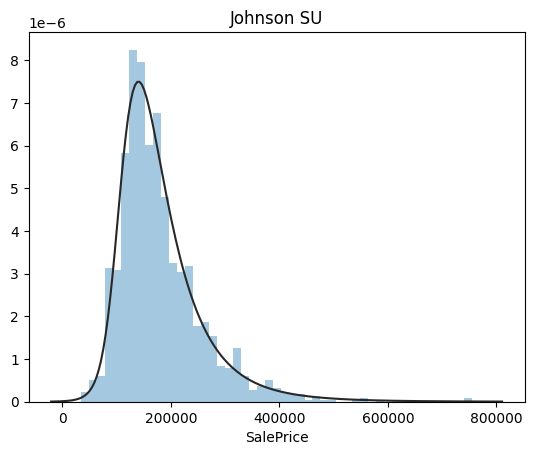

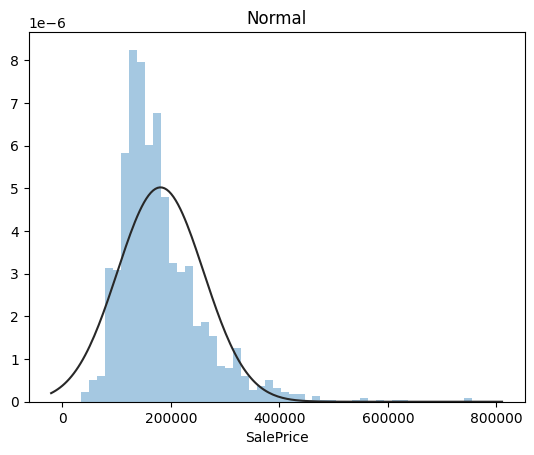

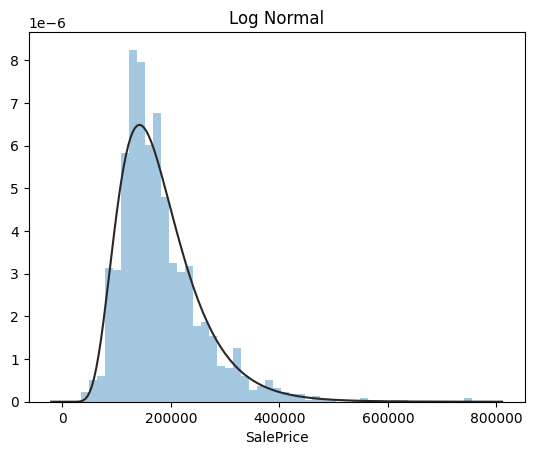

In [ ]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

Let's check the distribution for the other columns of the data set. As you can see, they all do not match the normal distribution.

In [ ]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(features[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


/home/fitiavana/.local/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Let's normalize the price column using the above log-normal distribution.

In [ ]:
y = np.log1p(y)
y = y.reset_index(drop=True)

Let's look at the current distribution of the target column. As we can see, it now corresponds to the normal distribution.

/tmp/ipykernel_7671/2593453836.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.johnsonsu)
/tmp/ipykernel_7671/2593453836.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.norm)
/tmp/ipykernel_7671/2593453836.py:6: UserWarning: 

`distplot` is

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

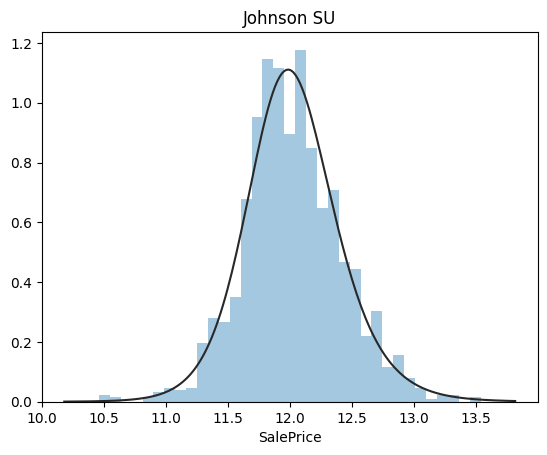

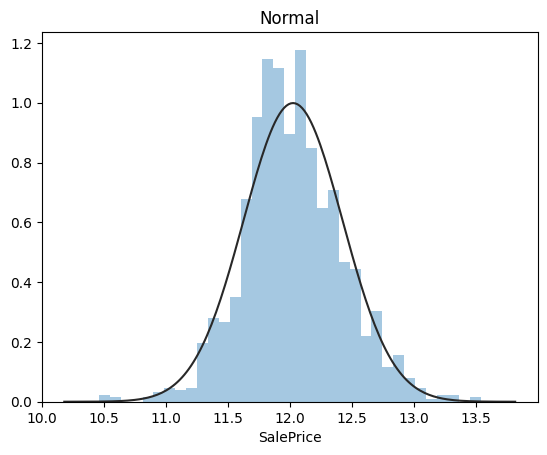

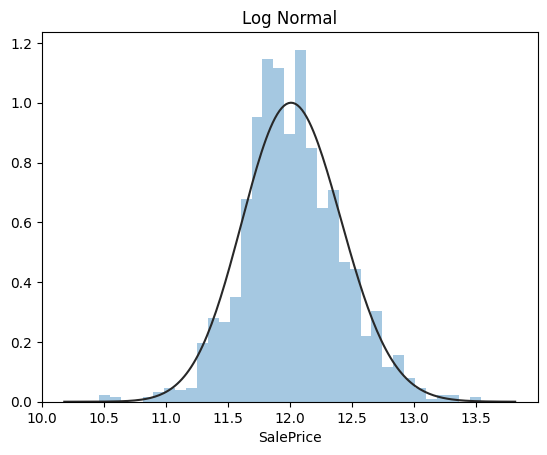

In [ ]:
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

We normalize the remaining columns in a similar manner.

In [ ]:
numerics = []
for i in features.columns:
    if features[i].name in quantitative:
        numerics.append(i)
skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

from scipy.stats import yeojohnson

for i in skew_index:
    if features[i].nunique() > 1:
        features[i], _ = yeojohnson(features[i])

/tmp/ipykernel_7671/3671417700.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)


Let's split the training and testing datasets for further model training and testing.

In [ ]:
X = features.iloc[:len(y), :]
X_sub = features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((1460, 72), (1460,), (1459, 72))

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# MODELS

As a model, after a series of tests, it was decided to use stacking according to a number of the most popular approaches to solving the regression problem.

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=10000000, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=10000000, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

catboost = CatBoostRegressor(iterations=3000,
                          early_stopping_rounds=100,
                          grow_policy = 'Depthwise',
                          depth=8,
                          l2_leaf_reg = 1,
                          learning_rate=0.03,
                          verbose=10)


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm, catboost),
                                meta_regressor=lightgbm,
                                use_features_in_secondary=True)

In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

START Fit
stack_gen


/home/fitiavana/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/fitiavana/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/fitiavana/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/fitiavana/.local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:42:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

Let's perform model prediction on test data followed by denormalization of the target column.

In [ ]:
y_pred = np.floor(np.expm1(stack_gen_model.predict(np.array(X_sub))))

print(f'number of rows: {len(y_pred)}')
y_pred

In [ ]:
submission = pd.read_csv('./sample_submission.csv')

In [ ]:
submission['SalePrice'] = y_pred

In [ ]:
submission.to_csv('submission.csv', index=False)

NameError: name 'submission' is not defined

In [ ]:
#pip install numpy pandas matplotlib seaborn scipy scikit-learn mlxtend xgboost lightgbm catboost optuna


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


The result was a submission.csv file with a score of 0.12173.